In [4]:
import numpy as np
import pykitti
import open3d as o3d

# 读取数据集

In [5]:
# 读取数据集
basedir = 'datasets'
date = '2011_10_03'
drive = '0027'
dataset = pykitti.raw(basedir, date, drive)

In [6]:
# 读取点云数据
data = dataset.get_velo(0)
print('origin data shape: ', data.shape) # x, y, z, reflectance
# 创建一个空的点云对象
point_cloud = o3d.geometry.PointCloud()
# 将 xyz 数据填充到点云中
point_cloud.points = o3d.utility.Vector3dVector(data[:, :3])
print(point_cloud)
print('point cloud shape: ', np.asarray(point_cloud.points).shape)

origin data shape:  (124668, 4)
PointCloud with 124668 points.
point cloud shape:  (124668, 3)


# 基本操作

In [7]:
# o3d可视化原始点云（适用于大点云，没有坐标）
o3d.visualization.draw_geometries([point_cloud])

In [8]:
# 进行体素下采样
voxel_size = 2.0  # 体素大小，根据需要调整
downsampled_point_cloud = point_cloud.voxel_down_sample(voxel_size)
print('downsampled point cloud shape: ', np.asarray(downsampled_point_cloud.points).shape)
# 可视化降采样后的点云
o3d.visualization.draw_geometries([downsampled_point_cloud])

downsampled point cloud shape:  (1616, 3)


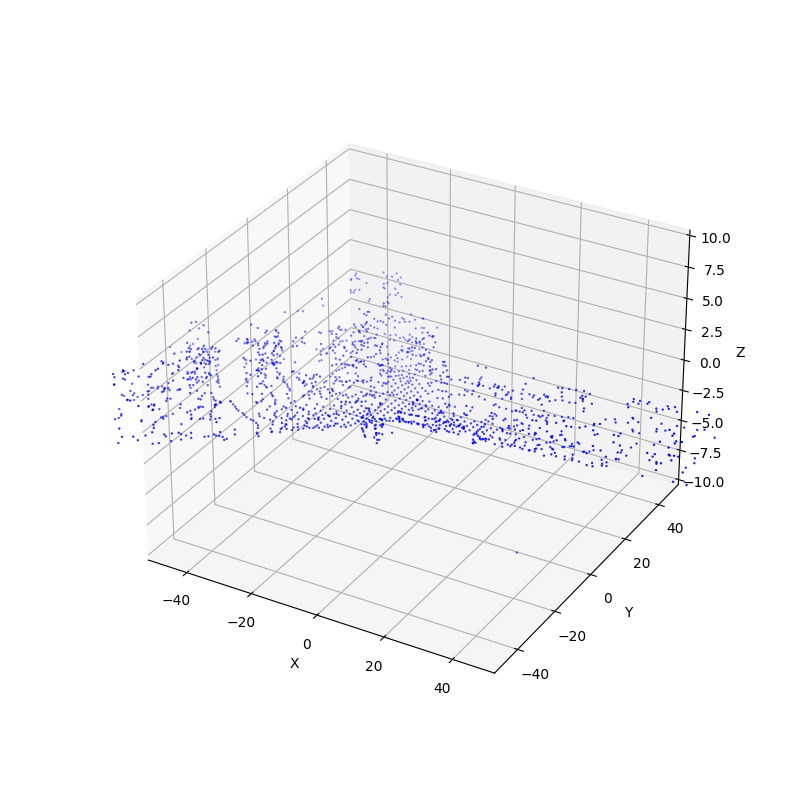

In [9]:
%matplotlib widget
# matplotlib可视化原始点云（适用于小点云，有坐标）
import matplotlib.pyplot as plt
def draw_numpy_point_cloud(ax, pc, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None, color='blue'):
    ax.scatter(pc[:, axes[0]], pc[:, axes[1]], pc[:, axes[2]], s=0.5, c=color)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

downsampled_point_cloud_np = np.asarray(downsampled_point_cloud.points)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, downsampled_point_cloud_np, xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10])

Transformation Matrix: 
 [[ 1.  1.  0. 30.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


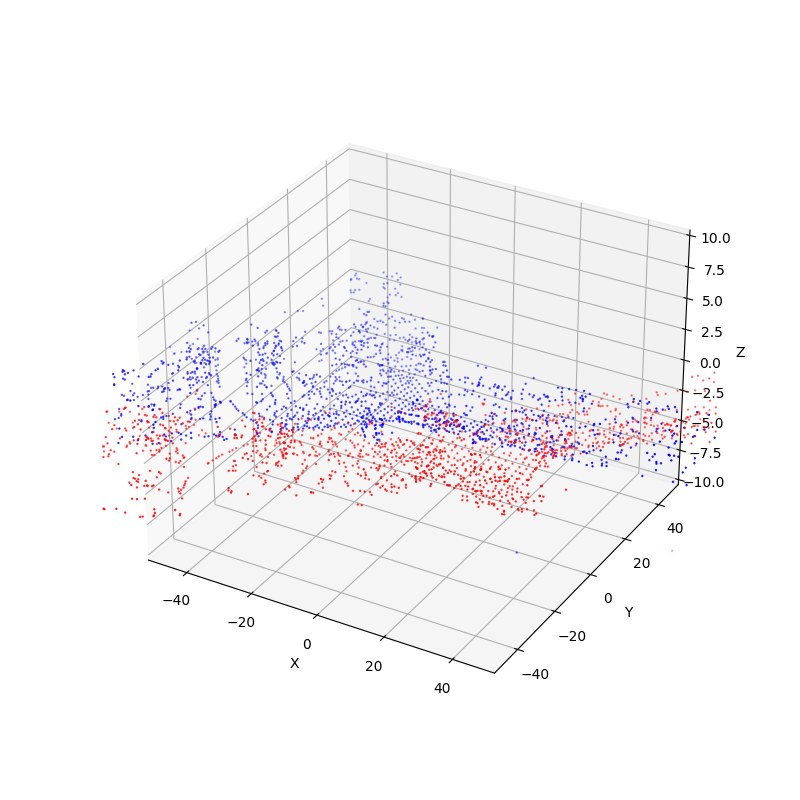

In [10]:

import copy
# 变换点云坐标系
R = np.array([[1, 1, 0],
              [1, 0, 0],
              [0, 0, 1]])
# 沿着 X 轴平移 10 个单位
t = np.array([30, 0, 0])
# 变换矩阵
T = np.eye(4)
T[:3, :3] = R
T[:3, 3] = t
print('Transformation Matrix: \n', T)
# 变换点云
transformed_point_cloud = copy.deepcopy(point_cloud.voxel_down_sample(voxel_size)).transform(T)
# 对比变换前后的点云
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, downsampled_point_cloud_np, xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='blue')
draw_numpy_point_cloud(ax, np.asarray(transformed_point_cloud.points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='red')

# ICP配准

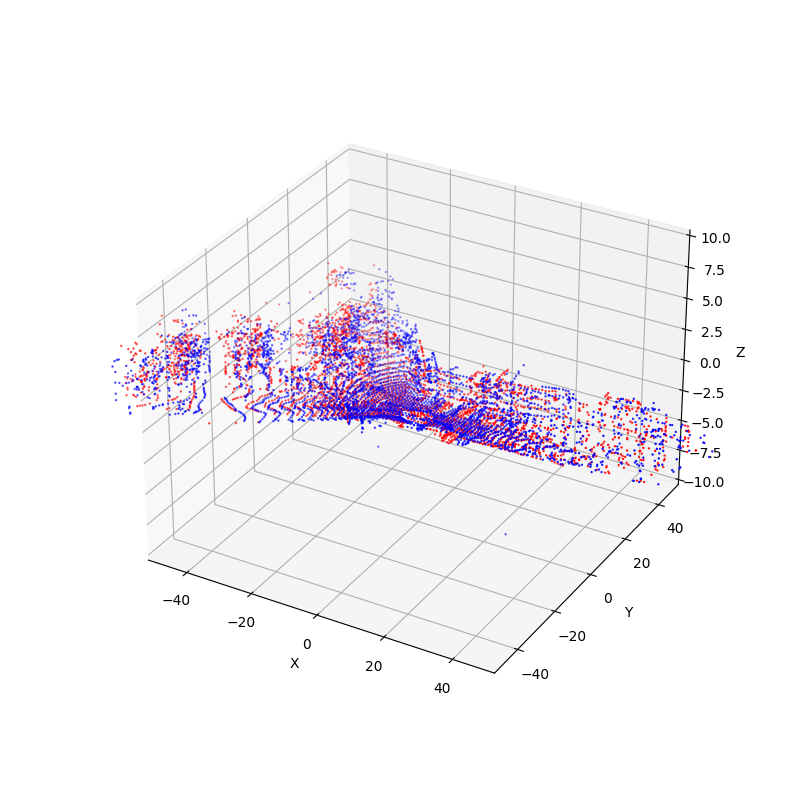

In [11]:
data1 = dataset.get_velo(5)
data2 = dataset.get_velo(10)
point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(data1[:, :3])
point_cloud2 = o3d.geometry.PointCloud()
point_cloud2.points = o3d.utility.Vector3dVector(data2[:, :3])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
draw_numpy_point_cloud(ax, np.asarray(point_cloud1.voxel_down_sample(1.0).points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='blue')
draw_numpy_point_cloud(ax, np.asarray(point_cloud2.voxel_down_sample(1.0).points), xlim3d=[-50, 50], ylim3d=[-50, 50], zlim3d=[-10, 10], color='red')

In [12]:
# o3d可视化点云配准结果
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [13]:
T = np.eye(4)
t = np.array([0, 0, 0])
T[:3, 3] = t
draw_registration_result(point_cloud1, point_cloud2, T)

In [14]:
# ICP配准
reg_p2p = o3d.pipelines.registration.registration_icp(
    point_cloud1, point_cloud2, 0.5, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(point_cloud1, point_cloud2, reg_p2p.transformation)

RegistrationResult with fitness=7.021320e-01, inlier_rmse=1.853009e-01, and correspondence_set size of 87011
Access transformation to get result.
Transformation is:
[[ 9.99710401e-01  2.32479238e-02 -6.21670609e-03 -7.19576667e-02]
 [-2.32521294e-02  9.99729450e-01 -6.05066136e-04  9.00456505e-02]
 [ 6.20095763e-03  7.49442563e-04  9.99980493e-01 -4.05565185e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# 滤除地面

In [15]:
# 滤除地面点(z<0.1)
ground_filter1 = np.asarray(point_cloud1.points)
ground_filter1 = ground_filter1[ground_filter1[:, 2] > 0.1]
ground_filter1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter1))
print('ground_filter1 shape: ', np.asarray(ground_filter1.points).shape)
ground_filter2 = np.asarray(point_cloud2.points)
ground_filter2 = ground_filter2[ground_filter2[:, 2] > 0.1]
ground_filter2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter2))
print('ground_filter2 shape: ', np.asarray(ground_filter2.points).shape)
# 可视化滤除地面点后的点云
T = np.eye(4)
t = np.array([0, 0, 0])
T[:3, 3] = t
draw_registration_result(ground_filter1, ground_filter2, T)

ground_filter1 shape:  (14622, 3)
ground_filter2 shape:  (14932, 3)


In [16]:
# 去中心化
ground_filter1 = np.asarray(ground_filter1.points)
ground_filter2 = np.asarray(ground_filter2.points)
ground_filter1 -= np.mean(ground_filter1, axis=0)
ground_filter2 -= np.mean(ground_filter2, axis=0)
# 转回o3d格式
ground_filter1 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter1))
ground_filter2 = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground_filter2))

In [17]:
# ICP配准
reg_p2p = o3d.pipelines.registration.registration_icp(
    ground_filter1, ground_filter2, 0.5, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(ground_filter1, ground_filter2, reg_p2p.transformation)

RegistrationResult with fitness=4.831760e-01, inlier_rmse=1.868882e-01, and correspondence_set size of 7065
Access transformation to get result.
Transformation is:
[[ 9.99734892e-01  2.29916218e-02  1.23729593e-03  7.78757156e-02]
 [-2.29906321e-02  9.99735354e-01 -8.08289564e-04  2.38722321e-01]
 [-1.25555237e-03  7.79629065e-04  9.99998908e-01  2.56619870e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [18]:
# 可视化正确的配准结果
index = np.asarray(reg_p2p.correspondence_set)
idx1 = index[:, 0]
idx2 = index[:, 1]
corresponding_point_cloud1 = ground_filter1.select_by_index(idx1)
corresponding_point_cloud2 = ground_filter2.select_by_index(idx2)
# draw_registration_result(corresponding_point_cloud1, corresponding_point_cloud2, reg_p2p.transformation)
success_rate = len(index) / len(ground_filter1.points)
print('success rate: ', success_rate)

success rate:  0.4831760361099713


# 真值比对

In [19]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def read_data(file_path):
    """
    读取数据文件并返回一个包含所有帧的列表。
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # 忽略时间戳，只读取位置和四元数
            position = np.array(parts[1:4], dtype=float)
            quaternion = np.array(parts[4:], dtype=float)
            R_cam2world = R.from_quat(quaternion).as_matrix()
            # 从相机坐标系转换到雷达坐标系(先绕y轴旋转90度，再绕x轴旋转-90度)
            R1 = R.from_euler('y', 90, degrees=True).as_matrix()
            R2 = R.from_euler('x', -90, degrees=True).as_matrix()
            R_lidar2cam = np.dot(R2, R1)
            R_lidar2world = np.dot(R_cam2world, R_lidar2cam)
            position = np.dot(R_cam2world, position)
            data.append((position, R_lidar2world))
    return data

def compute_transformation_matrix(frame1, frame2):
    """
    计算两帧之间的变换矩阵。
    """
    pos1, rot1 = frame1
    pos2, rot2 = frame2
    
    # 构建变换矩阵
    T1 = np.eye(4)
    T2 = np.eye(4)
    T1[:3, :3] = rot1
    T1[:3, 3] = pos1
    T2[:3, :3] = rot2
    T2[:3, 3] = pos2

    T = np.dot(np.linalg.inv(T1), T2)
    return T

In [20]:
# 读取groundtruth
file_path = './datasets/2011_10_03/2011_10_03_drive_0027_sync/groundtruth.txt'
data = read_data(file_path)
print(data[5][0])
print(data[5][1])
print(data[10][0])
print(data[10][1])

[-0.27906905 -0.1660537   4.287794  ]
[[-0.00258617  0.01033094  0.99994329]
 [-0.99997985  0.00577016 -0.00264588]
 [-0.00579717 -0.99992999  0.01031581]]
[-0.64742218 -0.38033093  8.56751909]
[[-0.00504987  0.02066463  0.99977371]
 [-0.99991945  0.0115373  -0.00528907]
 [-0.01164399 -0.99971989  0.0206047 ]]


In [21]:
# 计算前一帧和后一帧之间的变换矩阵
transformation_matrix = compute_transformation_matrix(data[5], data[10])
print(transformation_matrix)

[[ 9.99979871e-01 -5.79496604e-03  2.58392975e-03  1.90415247e-01]
 [ 5.82130517e-03  9.99929955e-01 -1.03051751e-02 -4.28446730e+00]
 [-2.52403062e-03  1.03200095e-02  9.99943562e-01 -3.23616455e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [22]:
# 使用真实的变换矩阵变换点云
draw_registration_result(ground_filter2, ground_filter1, transformation_matrix)

# 映射到range image

In [23]:
class LaserScan:
  """Class that contains LaserScan with x,y,z,r"""
  EXTENSIONS_SCAN = ['.bin']

  def __init__(self, project=False, H=64, W=1024, fov_up=3.0, fov_down=-25.0):
    self.project = project
    self.proj_H = H
    self.proj_W = W
    self.proj_fov_up = fov_up
    self.proj_fov_down = fov_down
    self.reset()

  def reset(self):
    """ Reset scan members. """
    self.points = np.zeros((0, 3), dtype=np.float32)        # [m, 3]: x, y, z
    self.remissions = np.zeros((0, 1), dtype=np.float32)    # [m ,1]: remission

    # projected range image - [H,W] range (-1 is no data)
    self.proj_range = np.full((self.proj_H, self.proj_W), -1,
                              dtype=np.float32)

    # unprojected range (list of depths for each point)
    self.unproj_range = np.zeros((0, 1), dtype=np.float32)

    # projected point cloud xyz - [H,W,3] xyz coord (-1 is no data)
    self.proj_xyz = np.full((self.proj_H, self.proj_W, 3), -1,
                            dtype=np.float32)

    # projected remission - [H,W] intensity (-1 is no data)
    self.proj_remission = np.full((self.proj_H, self.proj_W), -1,
                                  dtype=np.float32)

    # projected index (for each pixel, what I am in the pointcloud)
    # [H,W] index (-1 is no data)
    self.proj_idx = np.full((self.proj_H, self.proj_W), -1,
                            dtype=np.int32)

    # for each point, where it is in the range image
    self.proj_x = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: x
    self.proj_y = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: y

    # mask containing for each pixel, if it contains a point or not
    self.proj_mask = np.zeros((self.proj_H, self.proj_W),
                              dtype=np.int32)       # [H,W] mask

  def size(self):
    """ Return the size of the point cloud. """
    return self.points.shape[0]

  def __len__(self):
    return self.size()

  def open_scan(self, filename):
    """ Open raw scan and fill in attributes
    """
    # reset just in case there was an open structure
    self.reset()

    # check filename is string
    if not isinstance(filename, str):
      raise TypeError("Filename should be string type, "
                      "but was {type}".format(type=str(type(filename))))

    # check extension is a laserscan
    if not any(filename.endswith(ext) for ext in self.EXTENSIONS_SCAN):
      raise RuntimeError("Filename extension is not valid scan file.")

    # if all goes well, open pointcloud
    scan = np.fromfile(filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission
    self.set_points(points, remissions)

  def set_points(self, points, remissions=None):
    """ Set scan attributes (instead of opening from file)
    """
    # reset just in case there was an open structure
    self.reset()

    # check scan makes sense
    if not isinstance(points, np.ndarray):
      raise TypeError("Scan should be numpy array")

    # check remission makes sense
    if remissions is not None and not isinstance(remissions, np.ndarray):
      raise TypeError("Remissions should be numpy array")

    # put in attribute
    self.points = points    # get xyz
    if remissions is not None:
      self.remissions = remissions  # get remission
    else:
      self.remissions = np.zeros((points.shape[0]), dtype=np.float32)

    # if projection is wanted, then do it and fill in the structure
    if self.project:
      self.do_range_projection()

  def do_range_projection(self):
    """ Project a pointcloud into a spherical projection image.projection.
        Function takes no arguments because it can be also called externally
        if the value of the constructor was not set (in case you change your
        mind about wanting the projection)
    """
    # laser parameters
    fov_up = self.proj_fov_up / 180.0 * np.pi      # field of view up in rad
    fov_down = self.proj_fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

    # get depth of all points
    depth = np.linalg.norm(self.points, 2, axis=1)

    # get scan components
    scan_x = self.points[:, 0]
    scan_y = self.points[:, 1]
    scan_z = self.points[:, 2]

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= self.proj_W                              # in [0.0, W]
    proj_y *= self.proj_H                              # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(self.proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]
    self.proj_x = np.copy(proj_x)  # store a copy in orig order

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(self.proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]
    self.proj_y = np.copy(proj_y)  # stope a copy in original order

    # copy of depth in original order
    self.unproj_range = np.copy(depth)

    # order in decreasing depth
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    points = self.points[order]
    remission = self.remissions[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    self.proj_range[proj_y, proj_x] = depth
    self.proj_xyz[proj_y, proj_x] = points
    self.proj_remission[proj_y, proj_x] = remission
    self.proj_idx[proj_y, proj_x] = indices
    self.proj_mask = (self.proj_idx > 0).astype(np.int32)

In [24]:
def do_range_projection(self):
    """ Project a pointcloud into a spherical projection image.projection.
        Function takes no arguments because it can be also called externally
        if the value of the constructor was not set (in case you change your
        mind about wanting the projection)
    """
    # laser parameters
    fov_up = self.proj_fov_up / 180.0 * np.pi      # field of view up in rad
    fov_down = self.proj_fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

    # get depth of all points
    depth = np.linalg.norm(self.points, 2, axis=1)

    # get scan components
    scan_x = self.points[:, 0]
    scan_y = self.points[:, 1]
    scan_z = self.points[:, 2]

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= self.proj_W                              # in [0.0, W]
    proj_y *= self.proj_H                              # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(self.proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]
    self.proj_x = np.copy(proj_x)  # store a copy in orig order

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(self.proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]
    self.proj_y = np.copy(proj_y)  # stope a copy in original order

    # copy of depth in original order
    self.unproj_range = np.copy(depth)

    # order in decreasing depth
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    points = self.points[order]
    remission = self.remissions[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    self.proj_range[proj_y, proj_x] = depth
    self.proj_xyz[proj_y, proj_x] = points
    self.proj_remission[proj_y, proj_x] = remission
    self.proj_idx[proj_y, proj_x] = indices
    self.proj_mask = (self.proj_idx > 0).astype(np.int32)

对第0帧的点云进行映射

In [25]:
data = dataset.get_velo(0)
print('origin data shape: ', data.shape) # x, y, z, reflectance

origin data shape:  (124668, 4)


In [26]:
laserscan = LaserScan(project=True)
# 填充点云数据
points = data[:, :3]  # x, y, z
remissions = data[:, 3]  # 反射率
laserscan.set_points(points, remissions)
# 执行范围投影
laserscan.do_range_projection()
# 访问投影结果
range_image = laserscan.proj_range
xyz_image = laserscan.proj_xyz
remission_image = laserscan.proj_remission


In [27]:
print('range_image shape: ', range_image.shape) # x, y, z, reflectance

range_image shape:  (64, 1024)


range_image可视化

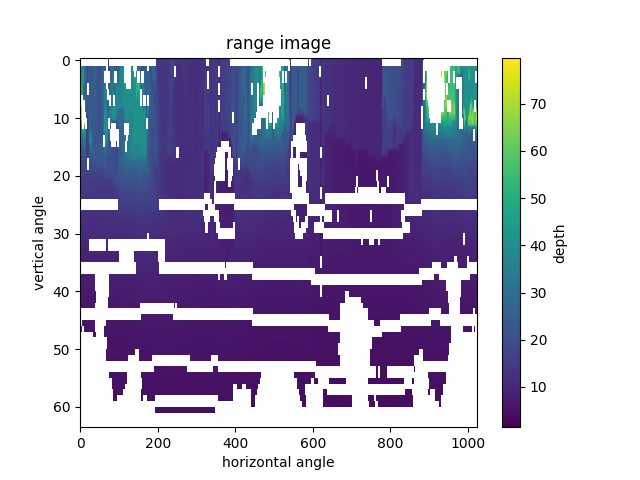

In [28]:
# 复制 viridis 颜色映射
cmap = plt.cm.viridis.copy()

# 设置 bad 数据为透明
cmap.set_bad(color='none')

range_image = laserscan.proj_range

# 将负值替换为 NaN，使其在图像中显示为透明
range_image[range_image < 0] = np.nan

plt.figure()
# 绘制图像
plt.imshow(range_image, cmap=cmap, aspect='auto')
plt.colorbar(label='depth')
plt.title("range image")
plt.xlabel("horizontal angle")
plt.ylabel("vertical angle")
plt.show()